In [77]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold




## 1. The data and problem

For this lesson, we'll work with a new dataset of unknown origin (for the moment). 

In a not too unbelievable scenario, imagine that your boss has given you these data and said, "I don't really know what all of this stuff means, but I need you to model this and get me a model to predict $y$ using these data!", and of course they add, "I need this by the end of the day!"
![Drawing of a boss and person at computer](images/the_boss_small.jpg)


Let's load the data and start looking at it...

In [78]:
df = pd.read_csv('data/regularization.csv')

In [79]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,y
0,0.126504,0.477706,0.313475,0.514386,0.743750,0.234681,0.671997,0.270976,0.519267,0.361153,...,0.571807,0.281180,0.814374,0.527172,0.550691,0.021509,0.028173,0.837283,0.261703,4.077128
1,0.121590,0.483381,0.724387,0.818556,0.872479,0.441711,0.795640,0.474486,0.157817,0.251904,...,0.403155,0.372762,0.226465,0.002351,0.089564,0.913374,0.911584,0.784988,0.035362,4.981252
2,0.698551,0.036947,0.723721,0.459921,0.602351,0.560279,0.028867,0.414398,0.104540,0.906528,...,0.960674,0.529909,0.911473,0.828246,0.468373,0.582552,0.527382,0.470915,0.756324,6.649698
3,0.198011,0.724938,0.713586,0.493570,0.812774,0.665962,0.496994,0.145470,0.929903,0.299357,...,0.370109,0.862206,0.275417,0.717374,0.265629,0.952450,0.387913,0.477727,0.566269,6.034292
4,0.160674,0.462549,0.399120,0.062895,0.933785,0.942120,0.269115,0.780801,0.452808,0.047896,...,0.766598,0.838162,0.351654,0.207323,0.760390,0.860970,0.993952,0.417981,0.991003,7.588461


What should we do with this? We have 20 $x$ variables and 50 observations of those variables. How can we build a good predictive model for these data?

Where do we start?

Once we're ready to start looking at models, how do we select variables?

### Number of possible models

As a bit of an aside, model selection quickly blows up if we want to try all possible combinations. The table below shows the number of models that would need to be evaluated for $p$ features or predictors.

$p$ (number of predictors): | 1      | 2     | 10    | 20    | 40    | 100 
--------------------------|--------|---------|-------|-------|-------|-----
No of models for $p$ predictors| 2   |  4    | 1,024 | 1,0448,576| 1.1 X 10<sup>12</sup> | 1.3 X 10<sup>30</sup>
Add square of each predictor | 4 | 16 | 1,048,576 | 1.1 X 10<sup>12</sup> | 1.2 X 10<sup>24</sup> | 1.6 X 10<sup>60</sup>
Add pairwise interactions | 2 | 5 | 3.6 X 10<sup>13</sup> | 1.6 X 10<sup>57</sup> | 6.4 X 10<sup>234</sup> | ? 🤯 

**Fun fact:** Estimated number of atoms in the observable universe: ~10<sup>80</sup>

So...with 20 features, we are approaching the number of atoms in the universe...

Somehow need to control for the number of parameters in our model!


## 2. Multiple linear regression

Let's explore multiple linear regression first to see what happens. _Note that, in the interest of time, I am leaving out exploratory data analyses and visualizations, which is where you should start!_

In [80]:
#get dataset ready
X = df.drop(columns=['y'])
y = df.y

model = LinearRegression()
model.fit(X, y)

def mse(model, X, y):
    y_hat = model.predict(X)
    err = np.mean((y - y_hat) ** 2)
    return err

print('R^2:', model.score(X, y), 'MSE:', mse(model, X, y))


R^2: 0.9679699534659556 MSE: 0.07828974536159017


Now that we've got a model, let's use 5-fold cross-validation to estimate how well it will work for new (i.e., non-training) data.

In [81]:
kf = KFold(n_splits=5)

res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = np.mean(res)
res = cross_val_score(model, X, y, cv=kf)
cv_r2= np.mean(res)

print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

c-v R^2: 0.7734350974615247 c-v MSE: 0.38341921219406266


## 3. Lasso regularization

Remember that a model that is too complex, we tend to overfit the training data and get high variance, and if it's not complex enough, we underfit the training data and get high bias. Our goal is to find the model with just enough complexity. We can try to do this as part of the model optimization procedure.

So far, we've user the $MSE$ as our loss function. And our models look something like this:

$$ \hat{y} = b_0 + b_{1}x_{1} + b_{2}x_{2} + \ldots + b_{p}x_{p} $$

Let's define:  $\ell_1 penalty = \lambda \sum_{i=1}^{p} |b_{p}|$

And then we can make a new loss function that is: 

   $$  loss = MSE +  \lambda \sum_{i=1}^{p} |b_{p}|$$

As the coefficient for a feature increases, the $\ell_1 penalty$ also increases. If the model can push the $b$ for a feature to 0, that feature drops out of the model. By adjusting $\lambda$, we can adjust the effect of the $\ell_1 penalty$.

This is known as the Lasso, short for **l**east **a**bsolute **s**hrinkage and **s**election **o**perator.

Okay, so let's see what the lasso ($\ell_1$-regularized regression) does with these data.  We can use scikit-learn's `Lasso` estimator for this.  Note that scikit-learn uses `alpha` for the name of the parameter referred to as $\lambda$ virtually everywhere else (perhaps because `lambda` is a reserved word in Python).

As a general practice, you should always **make sure that your predictor variables are on the same scale when fitting a regularized regression model**.  We can have `Lasso` do this for us automatically by passing `normalize=True` when we create the `Lasso` object.

In [82]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01))
])

model.fit(X, y)
print(model.named_steps['lasso'].coef_ / model.named_steps['scaler'].scale_)

res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)



[ 0.          2.07531097 -0.07765883  2.955528    0.01120125  0.19594985
  0.          0.04131297  0.15227467  0.09464139 -0.05563188  0.10460274
 -0.04104897  0.32482676 -0.06779785  0.47211508 -0.16832385  1.02321673
 -0.          4.28411995]
c-v R^2: 0.8600054286944238 c-v MSE: 0.25951580066352337


## 4. Ridge regression

Another method with similar goals, but different results is known as ridge regression. This uses what is referred to as the $\ell_1 penalty$

Let's define:  $\ell_2 penalty = \lambda \sum_{i=1}^{p} b_{p}^{2}$

Again, we can add the $\ell_1 penalty$ to the $MSE$.

Let's see what happens if we use ridge regression ($\ell_2$-regularized regression) with these data.  We can use scikit-learn's `Ridge` estimator to do this, and again, don't forget to make sure that your predictor variables are on the same scale.

All we need to do is copy the code from above and change `Lasso` to `Ridge` in the `model` line. The $\lambda$/`alpha` values have different effects.

In [83]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

model.fit(X, y)
print(model.named_steps['ridge'].coef_ / model.named_steps['scaler'].scale_)

res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)


[ 0.09531273  2.05605168 -0.10642754  2.9951993   0.07563958  0.27413443
  0.02878165  0.06294739  0.22054062  0.11140858 -0.1273955   0.16130407
 -0.09155563  0.39916988 -0.10958678  0.54319753 -0.18986193  1.04649947
 -0.09828673  4.20133833]
c-v R^2: 0.7800314571282306 c-v MSE: 0.39191244382243856


## 5. How does $\lambda$ influence the parameter estimates?

Before we move on, let's take a closer look at how changing lambda influences the parameter estimates for both the lasso and ridge regression.

**Affect of $\lambda$ in Lasso Regression**

![Graph showing how the features drop out as lambda is increased with Lasso. 4 key features are highlighted](images/Lasso_feature_dropout.png)

**Affect of $\lambda$ in Ridge Regression**

![Graph showing how the features drop out as lambda is increased with Ridge. 4 key features are highlighted](images/Ridge_feature_dropout.png)


Lasso and ridge regression are examples of *regularization* or *shrinkage* methods, because they regularize/constrain the parameter estimates by shrinking them towards 0.

## 6. Choosing $\lambda$ and a modeling procedure

How should we choose the "best" value of $\lambda$ for the lasso or ridge regression?  How should we decide whether to use the lasso or ridge regression?  What ideas do you have?

In [84]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lassoCV', LassoCV())
])

model.fit(X, y)
print(model.named_steps['lassoCV'].coef_ / model.named_steps['scaler'].scale_)
print(f"Lambda: (model.named_steps['lassoCV'].alpha_)")
res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

[-0.          1.75308926  0.          2.56644637 -0.          0.04514838
  0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.39082245 -0.          0.70328889
  0.          3.97175774]
Lambda: (model.named_steps['lassoCV'].alpha_)
c-v R^2: 0.8913493059968791 c-v MSE: 0.22966885202406004


In [85]:
lambdas = np.geomspace(0.1, 10, 100) # Unlike LassoCV, we need to provide the lambds, here we use a logarithmic scale.
                                    # Note that we need to update the search range--0.001 should be good in the end.
model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridgeCV', RidgeCV(alphas=lambdas))
])

model.fit(X, y)
print(model.named_steps['ridgeCV'].coef_)
print("Lambda:", model.named_steps["ridgeCV"].alpha_)

res = cross_val_score(model, X, y, cv=kf, scoring=mse)
cv_mse = res.mean()
res = cross_val_score(model, X, y, cv=kf)
cv_r2 = res.mean()
print("c-v R^2:", cv_r2, "c-v MSE:", cv_mse)



[ 0.02973356  0.58579287 -0.02993308  0.83274881  0.03241912  0.07202086
  0.00547985  0.02040299  0.05722947  0.03572423 -0.03561072  0.05761067
 -0.02938202  0.12904998 -0.03924181  0.13098626 -0.06743821  0.29128685
 -0.024115    1.30731279]
Lambda: 0.40370172585965547
c-v R^2: 0.7796457715211536 c-v MSE: 0.38131103114121356


## 7. Why/how do these methods work? Is one better than the other?

We'll start by revealing where the data we've been modeling actually came from, which will give us some insight into how these methods work.  Then we'll dig a little deeper into how these methods are able to decrease the expected test error.

These data were generated using: $y=1+ 2x_2 + 3x_4 + x_{18} + 4x_{20} + \epsilon ;    Var[\epsilon = 0.4] $

Look back the coefficients Lasso selected. Quite amazing!

### Returning to the bias-variance trade-off

The graph below shows the estimated test $MSE$ for models fit to data generated with the process used to generate the data we used in red. In blue is the Bias estimate and in green the variance. The vertical dashed line is the selected $\lambda$

![Graph of the estimated test MSE for models fit to data generated with the process used to generate the data we used in red. In blue is the Bias estimate and in green the variance.](images/Lasso_Bias-Variance_trade-off.png)
 
Notice that the model selected by Lasso does have bias! But we are trading a big reduction in variance for a small increase in bias.


### Key points to remember:

* The Lasso can drive coefficients to 0; thus, it can perform _feature selection_.
* Ridge regression constrains coefficient values (_shrinks_ them), but does not remove them from the model.

Which is best depends on your data and the goals of the analysis. In our case, most of the parameters were just noise, so Lasso performed better. If all of the parameters really played into generating the data, Ridge regression likely would have done better. **It depends on the data!**

## 8. Other methods

There are many other methods available for model/feature selection.  If you've had a statistics course, you've no doubt learned some of them.

Unfortunately, we don't have time to cover any of these alternative methods in detail in this course.  I will mention, though, that _dimensionality reduction_ is another widely used, general approach to dealing with model complexity and certainly worth learning about.  _Principle components regression_ is one example of this approach. One downside is that the models are less interpretable.

Another method I should mention is the _elastic net_, which combines $\ell_1$ and $\ell_2$ penalties into a single fitting procedure and can benefit from the desirable properties of both the lasso and ridge regression.

## 9. Data analysis lab

Now, put together everything that you've learned over the last few units (prediction error, bias and variance; methods for estimating test/prediction error; regularization techniques) and apply it to a data analysis problem.  Returning to the diabetes dataset, your goal is to create a machine learning model that can accurately predict the diabetes risk.

In [86]:
from sklearn.datasets import load_diabetes
X_diabetes, y_diabetes = load_diabetes(return_X_y=True)

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Step 1: Load the diabetes dataset
X_diabetes, y_diabetes = load_diabetes(return_X_y=True)



In [88]:
# Step 2: Data Exploration
print("Dataset shape:", X_diabetes.shape)
print("Mean target value:", np.mean(y_diabetes))
print("Standard deviation of target:", np.std(y_diabetes))
print("Feature correlation with target:")
print(pd.DataFrame(X_diabetes, columns=load_diabetes().feature_names).corrwith(pd.Series(y_diabetes)))

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.2, random_state=42)



Dataset shape: (442, 10)
Mean target value: 152.13348416289594
Standard deviation of target: 77.00574586945044
Feature correlation with target:
age    0.187889
sex    0.043062
bmi    0.586450
bp     0.441482
s1     0.212022
s2     0.174054
s3    -0.394789
s4     0.430453
s5     0.565883
s6     0.382483
dtype: float64


In [89]:
# Step 4: Define a function to calculate MSE
def mse(model, X, y):
    y_hat = model.predict(X)
    return np.mean((y - y_hat) ** 2)

#  basic multiple linear regression model
print("\n Multiple Linear Regression ")
model = LinearRegression()
model.fit(X_train, y_train)
print('R^2:', model.score(X_train, y_train), 'MSE:', mse(model, X_train, y_train))

# Step 6: Cross-validation for Linear Regression
kf = KFold(n_splits=5)
res = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
cv_r2 = np.mean(res)
res = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mse = np.mean(-res)
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

#  Lasso Regularization
print("\n Lasso Regression ")
lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lassoCV', LassoCV(cv=5))
])
lasso.fit(X_train, y_train)
print('Lasso Coefficients:', lasso.named_steps['lassoCV'].coef_)
print(f"Best Lambda (Lasso): {lasso.named_steps['lassoCV'].alpha_}")
res = cross_val_score(lasso, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mse = np.mean(-res)
res = cross_val_score(lasso, X_train, y_train, cv=kf, scoring='r2')
cv_r2 = np.mean(res)
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)




 Multiple Linear Regression 
R^2: 0.5279193863361498 MSE: 2868.549702835577
c-v R^2: 0.44925647412212166 c-v MSE: 3143.0153074277237

 Lasso Regression 


Lasso Coefficients: [  0.          -7.98057005  26.18568753  15.04178812  -4.80548329
  -0.         -11.07188471   0.          21.96231777   1.73878485]
Best Lambda (Lasso): 1.6552151706972245
c-v R^2: 0.44480952300827725 c-v MSE: 3175.662238087622


In [90]:
# Step 8: Apply Ridge Regression
print("\n Ridge Regression ")
ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridgeCV', RidgeCV(alphas=np.geomspace(0.1, 10, 100), cv=5))
])
ridge.fit(X_train, y_train)
print('Ridge Coefficients:', ridge.named_steps['ridgeCV'].coef_)
print(f"Best Lambda (Ridge): {ridge.named_steps['ridgeCV'].alpha_}")
res = cross_val_score(ridge, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_mse = np.mean(-res)
res = cross_val_score(ridge, X_train, y_train, cv=kf, scoring='r2')
cv_r2 = np.mean(res)
print('c-v R^2:', cv_r2, 'c-v MSE:', cv_mse)

# Step 9: Try Polynomial Regression
print("\nPolynomial Regression ")
param_grid = {'poly__degree': [1, 2, 3],
              'linreg__fit_intercept': [True, False]}

grid = GridSearchCV(Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('linreg', LinearRegression())
]), param_grid, cv=5)

grid.fit(X_train, y_train)
print(f'Best Params (Polynomial Regression): {grid.best_params_}')
best_poly_model = grid.best_estimator_




 Ridge Regression 
Ridge Coefficients: [  1.9313315  -11.02819247  25.60556062  16.30419091 -12.93423623
   0.53817343  -6.1251089    8.56948441  22.74930836   2.9181459 ]
Best Lambda (Ridge): 10.0
c-v R^2: 0.44663904883192707 c-v MSE: 3163.260187036742

Polynomial Regression 
Best Params (Polynomial Regression): {'linreg__fit_intercept': True, 'poly__degree': 1}



Comparing Models 


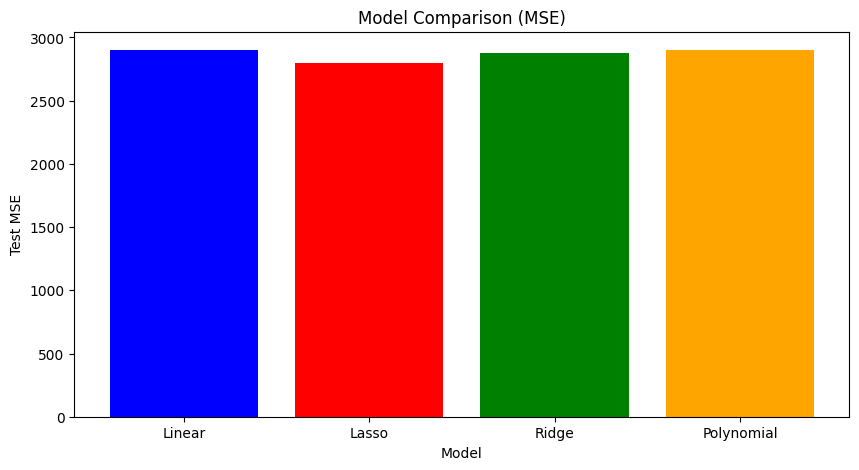

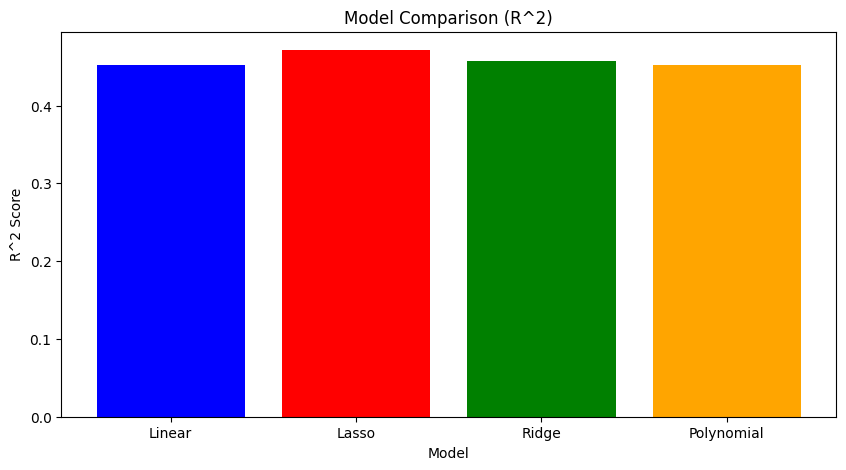

In [91]:
# Step 10: Model Comparison
print("\nComparing Models ")
models = ['Linear', 'Lasso', 'Ridge', 'Polynomial']
mses = [mse(model, X_test, y_test), mse(lasso, X_test, y_test), mse(ridge, X_test, y_test), mse(best_poly_model, X_test, y_test)]
r2_scores = [model.score(X_test, y_test), lasso.score(X_test, y_test), ridge.score(X_test, y_test), best_poly_model.score(X_test, y_test)]

# Step 11: Visualizing MSE Comparison
plt.figure(figsize=(10, 5))
plt.bar(models, mses, color=['blue', 'red', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Test MSE')
plt.title('Model Comparison (MSE)')
plt.show()

# Step 12: Visualizing R^2 Comparison
plt.figure(figsize=(10, 5))
plt.bar(models, r2_scores, color=['blue', 'red', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('Model Comparison (R^2)')
plt.show()


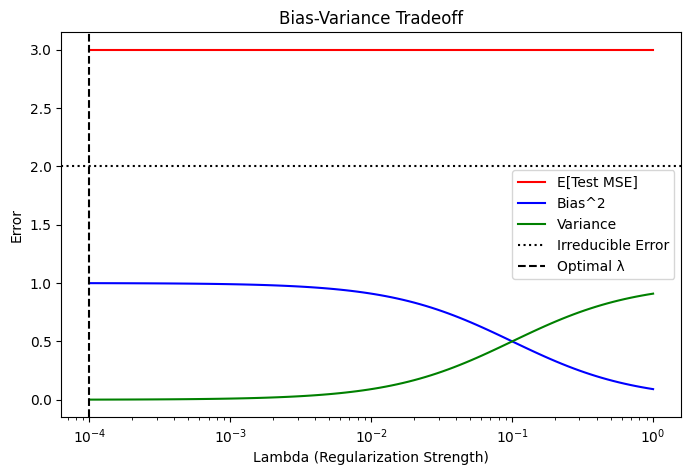

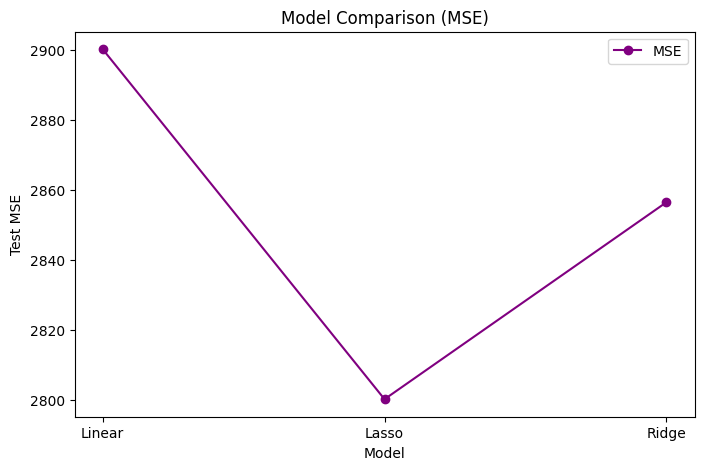

In [92]:
lambdas = np.logspace(-4, 0, 100)
bias = 1 / (1 + 10 * lambdas)
variance = 10 * lambdas / (1 + 10 * lambdas)
test_mse = bias + variance + 2

plt.figure(figsize=(8, 5))
plt.plot(lambdas, test_mse, label='E[Test MSE]', color='red')
plt.plot(lambdas, bias, label='Bias^2', color='blue')
plt.plot(lambdas, variance, label='Variance', color='green')
plt.axhline(y=2, color='black', linestyle='dotted', label='Irreducible Error')
plt.axvline(x=lambdas[np.argmin(test_mse)], linestyle='dashed', color='black', label='Optimal λ')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Error')
plt.legend()
plt.title('Bias-Variance Tradeoff')
plt.show()

# Step 8: Line plot for model comparison
models = ['Linear', 'Lasso', 'Ridge']
mses = [mse(model, X_test, y_test), mse(LassoCV(cv=5).fit(X_train, y_train), X_test, y_test), mse(RidgeCV(alphas=np.geomspace(0.1, 10, 100), cv=5).fit(X_train, y_train), X_test, y_test)]

plt.figure(figsize=(8, 5))
plt.plot(models, mses, marker='o', linestyle='-', color='purple', label='MSE')
plt.xlabel('Model')
plt.ylabel('Test MSE')
plt.title('Model Comparison (MSE)')
plt.legend()
plt.show()